# Linear regression model, KNN and feature importance - <br /> by Jerome, 29 November 2021 #

---

In [6]:
## load modules and run mlflow_logging.ipynb to get function to track model information on MLFLow
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

from modeling.functions import modelling, log_to_mlflow, get_features 

RSEED = 42

### Read data, remove NaNs and get dummies for cardinal wind directions ###

In [7]:
## read data
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'])
data.dropna(inplace=True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'])
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 175265 entries, 0 to 175433
Data columns (total 49 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ZONEID         175265 non-null  int64         
 1   TIMESTAMP      175265 non-null  datetime64[ns]
 2   TARGETVAR      175265 non-null  float64       
 3   U10            175265 non-null  float64       
 4   V10            175265 non-null  float64       
 5   U100           175265 non-null  float64       
 6   V100           175265 non-null  float64       
 7   HOUR           175265 non-null  int64         
 8   MONTH          175265 non-null  int64         
 9   WEEKDAY        175265 non-null  int64         
 10  IS_HOLIDAY     175265 non-null  int64         
 11  WS10           175265 non-null  float64       
 12  WS100          175265 non-null  float64       
 13  WD10           175265 non-null  float64       
 14  WD100          175265 non-null  float64       
 15  

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,...,0,1,0,0,0,0,0,0,0,0
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,...,0,1,0,0,0,0,0,0,0,0
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,...,0,0,0,0,0,0,0,0,1,0
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,...,0,0,0,0,0,0,0,1,0,0
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,...,0,0,0,0,0,0,0,1,0,0


### Train-test-split, get different combinations of features and perform linear regression for different feature combinations ###

In [8]:
## train-test-split
data_train, data_test = train_test_split(data, test_size=0.25, random_state=RSEED, stratify=data.ZONEID)

In [9]:
## get features
feature_dict = get_features(data)

In [10]:
## run model

results = {}

for key in feature_dict.keys(): 

    results[key] = {} 

    # linear regression
    results[key]['LR_train'], results[key]['LR_test'], _ \
        = modelling(data_train, data_test, feature_dict[key], LinearRegression(), scaler=None, print_scores=True, log=None, infotext_mlflow=None)
    results[key]['LR_train'] = {k : np.round(value,4) for k,value in results[key]['LR_train'].items()}
    results[key]['LR_test'] = {k : np.round(value,4) for k,value in results[key]['LR_test'].items()}

    # KNN
    results[key]['KNN_train'], results[key]['KNN_test'], _ \
        = modelling(data_train, data_test, feature_dict[key], KNeighborsRegressor(n_neighbors = 5, n_jobs = -1), \
                    scaler=MinMaxScaler(), print_scores=True, log=None, infotext_mlflow=None)
    results[key]['KNN_train'] = {k : np.round(value,4) for k,value in results[key]['KNN_train'].items()}
    results[key]['KNN_test'] = {k : np.round(value,4) for k,value in results[key]['KNN_test'].items()}


train-RMSE/test-RMSE linear regression model for ZONE1: 0.181 0.183
train-RMSE/test-RMSE linear regression model for ZONE2: 0.154 0.149
train-RMSE/test-RMSE linear regression model for ZONE3: 0.152 0.154
train-RMSE/test-RMSE linear regression model for ZONE4: 0.177 0.179
train-RMSE/test-RMSE linear regression model for ZONE5: 0.18 0.183
train-RMSE/test-RMSE linear regression model for ZONE6: 0.188 0.185
train-RMSE/test-RMSE linear regression model for ZONE7: 0.138 0.139
train-RMSE/test-RMSE linear regression model for ZONE8: 0.17 0.17
train-RMSE/test-RMSE linear regression model for ZONE9: 0.165 0.164
train-RMSE/test-RMSE linear regression model for ZONE10: 0.203 0.205
train-RMSE/test-RMSE linear regression model for TOTAL: 0.172 0.172
Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: -0.0, 1.02

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: 0.0, 1.0

Scaler: MinMaxScaler
Scaled X_train min/max: 0.0, 1.0
Scaled X_test min/max: 0

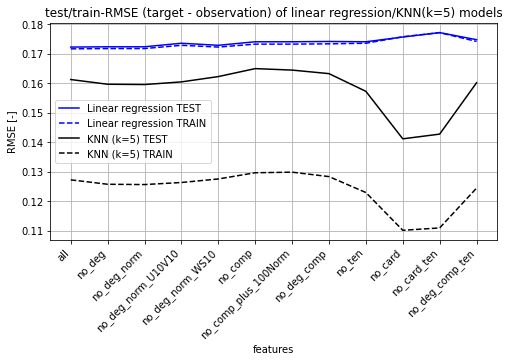

In [14]:
score = {'x':[], 'LR_test':[], 'LR_train':[], 'KNN_test':[], 'KNN_train':[]}

for key in feature_dict.keys():

    score['x'].append(key)
    score['LR_train'].append(results[key]['LR_train']['TOTAL'])
    score['LR_test'].append(results[key]['LR_test']['TOTAL'])
    score['KNN_train'].append(results[key]['KNN_train']['TOTAL'])
    score['KNN_test'].append(results[key]['KNN_test']['TOTAL'])

plt.figure(figsize=(8,4))
plt.plot(score['x'], score['LR_test'], 'b')
plt.plot(score['x'], score['LR_train'], linestyle='--', color='b')

plt.plot(score['x'], score['KNN_test'], 'k')
plt.plot(score['x'], score['KNN_train'], linestyle='--', color='k')

plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE [-]')
plt.xlabel('features')
plt.legend(['Linear regression TEST','Linear regression TRAIN', 'KNN (k=5) TEST', 'KNN (k=5) TRAIN'])
plt.title('test/train-RMSE (target - observation) of linear regression/KNN(k=5) models')
plt.grid()



In [15]:
feature_dict['no_card_ten']

['U100',
 'V100',
 'HOUR',
 'MONTH',
 'WEEKDAY',
 'IS_HOLIDAY',
 'WS100',
 'WD100',
 'U100NORM',
 'V100NORM']

In [12]:
results['no_card']

{'LR_train': {'ZONE1': 0.1848,
  'ZONE2': 0.1572,
  'ZONE3': 0.1588,
  'ZONE4': 0.1812,
  'ZONE5': 0.1828,
  'ZONE6': 0.1943,
  'ZONE7': 0.142,
  'ZONE8': 0.1731,
  'ZONE9': 0.1659,
  'ZONE10': 0.2069,
  'TOTAL': 0.1757},
 'LR_test': {'ZONE1': 0.1859,
  'ZONE2': 0.153,
  'ZONE3': 0.1594,
  'ZONE4': 0.1828,
  'ZONE5': 0.1858,
  'ZONE6': 0.1907,
  'ZONE7': 0.1433,
  'ZONE8': 0.1725,
  'ZONE9': 0.1645,
  'ZONE10': 0.2079,
  'TOTAL': 0.1756},
 'KNN_train': {'ZONE1': 0.1058,
  'ZONE2': 0.0956,
  'ZONE3': 0.0984,
  'ZONE4': 0.1174,
  'ZONE5': 0.1171,
  'ZONE6': 0.1198,
  'ZONE7': 0.088,
  'ZONE8': 0.1055,
  'ZONE9': 0.109,
  'ZONE10': 0.1362,
  'TOTAL': 0.1101},
 'KNN_test': {'ZONE1': 0.1402,
  'ZONE2': 0.1224,
  'ZONE3': 0.1293,
  'ZONE4': 0.1509,
  'ZONE5': 0.1494,
  'ZONE6': 0.1517,
  'ZONE7': 0.116,
  'ZONE8': 0.1334,
  'ZONE9': 0.1361,
  'ZONE10': 0.1728,
  'TOTAL': 0.1411}}

https://www.kaggle.com/ankitp013/interpreting-ml-models-eli5-lime-shap-yellowbrick

https://lightgbm.readthedocs.io/en/latest/

* linear regression, KNN, SVM, Boostings, RandomForest, Neuronal Networks